# Prevendo a População Ocupada no Brasil usando Séries Temporais

----

## Leitura dos Dados

In [1]:
## Já instalando bibliotecas necessárias
"""
from IPython.display import clear_output # limpa o output de uma célula
%pip install pmdarima

clear_output()  # limpando o texto
"""

'\nfrom IPython.display import clear_output # limpa o output de uma célula\n!pip install pmdarima\n\nclear_output()  # limpando o texto\n'

In [2]:
## Importando o que for necessário
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
## Montando o Google Drive
"""
from google.colab import drive
drive.mount('/content/drive')
"""

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [4]:
## Lendo os dados (trimestre iniciado em janeiro de 2012 ao iniciado em junho de 2021)
sCaminho = "/content/drive/Othercomputers/Meu modelo MacBook Air/Documents/IPEA/Curso IDP/Dados/"
sCaminho = "/Users/vinicius/Meu Drive/UnB/Econometria/datasets/IDP/"
sArquivo = "populacao_ocupada.xlsx"

## Lendo o DataFrame
df = pd.read_excel(f"{sCaminho}{sArquivo}")

# Vendo o tamanho da base
print(f"Linhas: {df.shape[0]}; Colunas: {df.shape[1]}")

Linhas: 114; Colunas: 2


In [5]:
## Convertendo a coluna de data pra datetime
df['data'] = pd.to_datetime(df['data'])

In [6]:
## Vendo o DataFrame
df.tail(12)

,data,ocupados
102,2020-09-01,82464
103,2020-10-01,84301
104,2020-11-01,85578
105,2020-12-01,86179
106,2021-01-01,86025
107,2021-02-01,85899
108,2021-03-01,85650
109,2021-04-01,85940
110,2021-05-01,86708
111,2021-06-01,87791


## Box-Jenkins: Identificação

[Text(0.5, 1.0, 'População Ocupada por Trimestre Móvel (milhares)'),
 Text(0.5, 0, 'Mês e Ano'),
 Text(0, 0.5, 'Ocupados')]

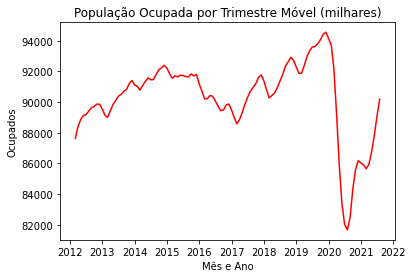

In [7]:
## Grafando o comportamento da série
plt.plot(df.data, df.ocupados, color="red")
plt.gca().set(title="População Ocupada por Trimestre Móvel (milhares)", xlabel="Mês e Ano", ylabel="Ocupados")

### Séries Estacionárias e Teste de Estacionariedade

Uma série é dita estacionária quando seus valores não são função do tempo.
Em outras palavras, suas propriedades estátisticas (média, variância, autocorrelação) são constantes ao longo do tempo, não havendo sazonalidade ou tendência.

Séries estacionárias são importantes porque facilitam a adoção de modelos preditivos (principalmente lineares).
Vimos que um dos pressupostos da Regressão Linear é que as variáveis independentes não podem ser auto-correlacionadas, o que não ocorre com séries estacionárias.

In [8]:
## Testando a estacionaridade da série
# Módulo
from statsmodels.tsa.stattools import adfuller, kpss

In [9]:
## Testando estacionariedade usando o teste Aumentado de Dickey Fuller (ADF)
resultado_adf = adfuller(df['ocupados'], autolag='AIC')
print(f"P-valor do teste: {resultado_adf[1]}")
print("H0: a série NÃO é estacionária e possui raiz unitária.")

# Rejeitamos H0: a série É estacionária

P-valor do teste: 0.0011921050683469062
H0: a série NÃO é estacionária e possui raiz unitária.


Já sabemos que a série é estacionária, o que significa que ela não é um passeio aleatório (que tende a ter sua variância aumentada linearmente com o tempo). 

Lembre que o passeio aleatório é expresso por:

$Y_t = Y_{t-1} + \epsilon_t$, onde $\epsilon_t$ é um ruído branco (erro aleatório). Note que a primeira-diferenciação do passeio aleatório produz um erro branco.

Assumindo que $Y_0$ = 0, $E[Y_t] = E[\epsilon_0 + \epsilon_1 + ... + \epsilon_t] = E[\epsilon_0] + E[\epsilon_1] + ... + E[\epsilon_t] = 0$.

Contudo, $Var(Y_t) = Var[\epsilon_0 + \epsilon_1 + ... + \epsilon_t] = Var[\epsilon_0] + Var[\epsilon_1] + ... + Var[\epsilon_t] = t \sigma^2$, de forma que a variância aumenta linearmente com o tempo e o desvio-padrão cresce de forma proporcional a $\sqrt{t}$.

Podemos visualizar a propriedade de médias e variâncias (desvios-padrão) constantes:

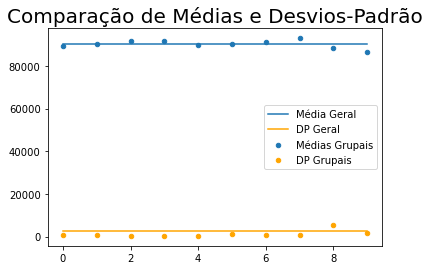

In [12]:
## Vendo comportamento da variância e desvio-padrão ao longo do tempo
# Separando o array em 20 grupos de tamanhos (quase) iguais (array_split)
chunks = np.array_split(df.ocupados.values, 10)

# Criando lista para armazenar médias e desvios-padrão
medias, desvios_padrao = [], []

# Média e desvio padrão de cada grupo
for chunk in chunks:
    medias.append(np.mean(chunk))
    desvios_padrao.append(np.std(chunk))

# Plottando
plt.title('Comparação de Médias e Desvios-Padrão', size=20)
plt.plot(np.arange(len(medias)), [np.mean(df.ocupados.values)] * len(medias), label='Média Geral', lw=1.5)
plt.scatter(x=np.arange(len(medias)), y=medias, label='Médias Grupais', s=20)
plt.plot(np.arange(len(desvios_padrao)), [np.std(df.ocupados.values)] * len(desvios_padrao), label='DP Geral', lw=1.5, color='orange')
plt.scatter(x=np.arange(len(desvios_padrao)), y=desvios_padrao, label='DP Grupais', color='orange', s=20)
plt.legend()

### Autocorrelação

Quanto maior a autocorrelação de uma série, mais úteis são os valores anteriores como preditores dos valores futuros.

#### Autocorrelação Total (*q*)

A autocorrelação da série sera útil na determinação do número de erros de previsão anteriores *(**q**)* no modelo ARIMA.

In [13]:
## Módulos necessários
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

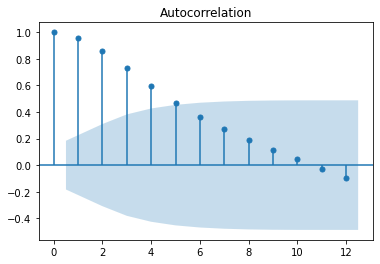

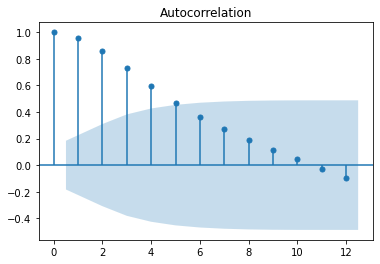

In [14]:
## Vendo a autocorrelação com valores até 1 anos antes
plot_acf(df.ocupados.tolist(), lags=12)

De quebra, já vemos que a série não é um ruído branco (há autocorrelação), uma vez que nossos "pirulitos" estão fora do intervalo sombreado (significância diferente de 0).

#### Autocorrelação Parcial (*p*)

A correlação parcial é extraída de

Y<sub>t</sub> = A + B<sub>1</sub> Y<sub>t-1</sub> + B<sub>2</sub> Y<sub>t-2</sub>...

Assim como em uma regressão, esses termos possuem interpretação de efeito **parcial**. A correlação parcial pode, portanto, ser interpretada como a correlação entre a série e seus valores anteriores EXCLUINDO-SE a contribuição da correlação de valores passados "intermediários".

A correlação parcial é especialmente útil na determinação do número de valores passados *(**p**)* a serem usados no modelo ARIMA.

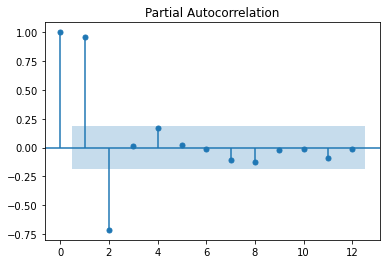

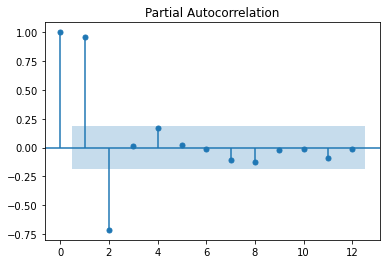

In [15]:
## Vendo a autocorrelação parcial com valores até 1 anos antes
plot_pacf(df.ocupados.tolist(), lags=12, method='ywm')

# Linha sombreada: intervalo de significância (dentro dela, a autocorrelação não é estatisticamente significante)

## Box-Jenkins: Estimação ~(e alguns diagnósticos e previsões)~




In [16]:
## Módulos necessários
from statsmodels.tsa.seasonal import seasonal_decompose  # decomposição
from dateutil.parser import parse  # decomposição
from statsmodels.tsa.holtwinters import ExponentialSmoothing  # Holt-Winter
from statsmodels.tsa.arima.model import ARIMA  # ARIMA (AR, MA, ARMA...)
from pmdarima.arima import auto_arima  # ARIMA automático

### Decomposição da Série

Uma série pode ser decomposta entre tendência, sazonalidade e erro de duas formas: aditiva e multiplicativa.

**Aditiva:**

Valor = Valor Base + Tendência + Sazonalidade + Erro

**Multiplicativa:**

Valor = Valor Base x Tendência x Sazonalidade x Erro

In [17]:
## Colocando data como index
df = df.set_index('data', drop=False)

# Especificando frequência mensal
df = df.asfreq('MS')

In [18]:
## Decomposição Aditiva
# extrapolate_trend cuida de valores nulos; aqui, isso não será um problema
resultados_aditiva = seasonal_decompose(df['ocupados'], model='additive')

## Decomposição Multiplicativa
resultados_multiplicativa = seasonal_decompose(df['ocupados'], model='multiplicative')

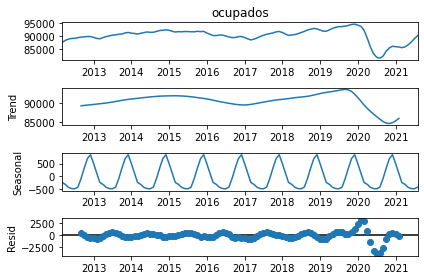

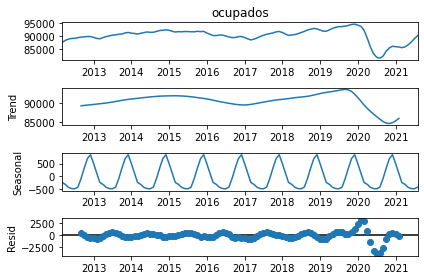

In [19]:
## Plottando
# Aditiva
resultados_aditiva.plot()

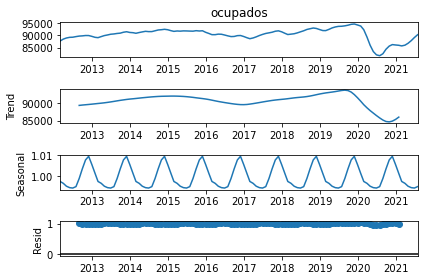

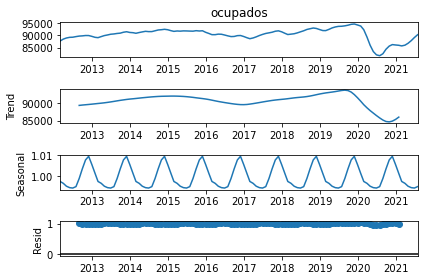

In [20]:
# Multiplicativa
resultados_multiplicativa.plot()

### Suavização Exponencial: Método Linear de Holt-Winter

In [21]:
## Método aditivo
holt_aditivo = ExponentialSmoothing(df.ocupados, trend="add", seasonal="add", 
                                    damped_trend=False, seasonal_periods=12).fit()
df['holt_aditivo'] = holt_aditivo.fittedvalues  # adicionando como coluna ao DataFrame


## Método multiplicativo
holt_multiplicativo = ExponentialSmoothing(df.ocupados, trend="mul", seasonal="mul", 
                                    damped_trend=False, seasonal_periods=12).fit()
df['holt_multiplicativo'] = holt_multiplicativo.fittedvalues

/Users/vinicius/opt/anaconda3/envs/datascience/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/vinicius/opt/anaconda3/envs/datascience/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/vinicius/opt/anaconda3/envs/datascience/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<AxesSubplot:title={'center':'Suavização Exponencial Aditiva'}, xlabel='data'>

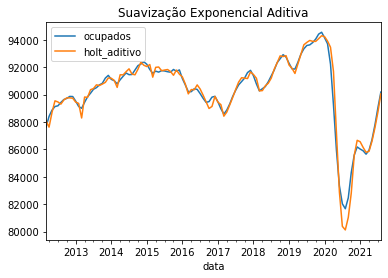

In [22]:
## Vendo resultados
# Aditivo
df[['ocupados','holt_aditivo']].plot(title="Suavização Exponencial Aditiva")

<AxesSubplot:title={'center':'Suavização Exponencial Multiplicativa'}, xlabel='data'>

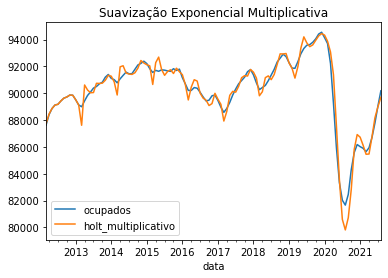

In [23]:
# Multiplicativo
df[['ocupados','holt_multiplicativo']].plot(title="Suavização Exponencial Multiplicativa")

#### Dados de Treino e Teste

In [24]:
## Separando dados de treino e de teste
nMeses = 6
treino = df.ocupados.values[:-nMeses]
teste = df.ocupados.values[-nMeses:]

## Criando indexes para os dados da previsão
index_previsao = pd.date_range(start=f'{9 - nMeses}/1/2021', periods=nMeses, freq="MS")

In [25]:
## Fittando o modelo (aditivo e multiplicativo)
holt_aditivo_treino = ExponentialSmoothing(treino, trend="add", seasonal="add", 
                                    damped_trend=False, seasonal_periods=12).fit()


## Método multiplicativo
holt_multiplicativo_treino = ExponentialSmoothing(treino, trend="mul", seasonal="mul", 
                                    damped_trend=False, seasonal_periods=12).fit()

/Users/vinicius/opt/anaconda3/envs/datascience/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/vinicius/opt/anaconda3/envs/datascience/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/vinicius/opt/anaconda3/envs/datascience/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [26]:
## Vendo o sumário (não nos é tããão útil)
print(holt_aditivo.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 ocupados   No. Observations:                  114
Model:             ExponentialSmoothing   SSE                       25633882.668
Optimized:                         True   AIC                           1436.848
Trend:                         Additive   BIC                           1480.627
Seasonal:                      Additive   AICC                          1444.048
Seasonal Periods:                    12   Date:                 Sun, 12 Dec 2021
Box-Cox:                          False   Time:                         17:44:41
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8572219                alpha                 True
smoothing_trend          

In [27]:
## Fazendo as previsões para os dois modelos
previsoes_aditivo = holt_aditivo_treino.forecast(nMeses)
previsoes_multiplicativo = holt_multiplicativo_treino.forecast(nMeses)

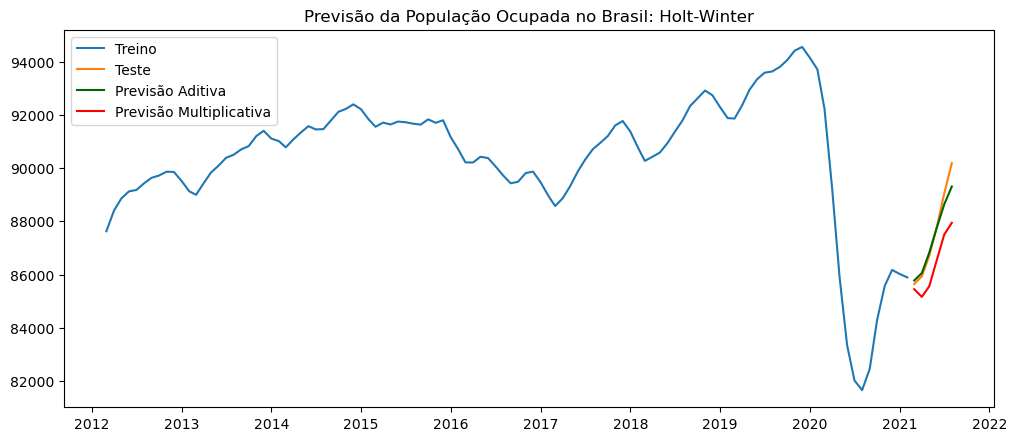

In [28]:
# Criando uma série com os valores de treino/teste para ter o index de data
serie_treino = pd.Series(treino, index=df.index.values[:-nMeses])
serie_teste = pd.Series(teste, index=df.index.values[-nMeses:])

# Criando as séries para plottar
serie_previsao_aditivo = pd.Series(previsoes_aditivo, index=index_previsao)
serie_previsao_multiplicativo = pd.Series(previsoes_multiplicativo, index=index_previsao)

## Plottando
plt.figure(figsize=(12,5), dpi=100)
# Série de treino
plt.plot(serie_treino, label="Treino")
# Série de teste
plt.plot(serie_teste, label="Teste")

## Previsão e Valores de Confiança
plt.plot(serie_previsao_aditivo, color='darkgreen', label="Previsão Aditiva")
plt.plot(serie_previsao_multiplicativo, color='red', label="Previsão Multiplicativa")

plt.title("Previsão da População Ocupada no Brasil: Holt-Winter")
plt.legend()
plt.show()

## Como o modelo é de suavização, ele não preve muito bem períodos de grande
## melhora/piora. Além disso, o statsmodels não fornece opções de intervalo de confiança
## para as previsões, o que ajudaria muito na análise gráficia

In [29]:
## Vendo algumas métricas da acurácia da previsão
def acuracia_previsao(previsao, dados_reais):
  """
  Função que calcula métricas acerca da qualidade (ou não) da previsão feita a partir de um modelo fittado com dados de teste.
  :param previsao: array unidimensional contendo os valores previstos;
  :param dados_reais: array unidimensional contendo os valores reais. Note que previsao e dados_reais tem de ter o mesmo tamanho.
  """

  ## MAPE: mean absolute percentage error (erro absoluto percentual médio)
  mape = np.mean(np.abs(previsao - dados_reais)/np.abs(dados_reais)) 
  ## MAE: mean absolute error (erro absoluto medio)
  mae = np.mean(np.abs(previsao - dados_reais))
  ## RMSE: root mean squared error (raiz do erro quadrático médio)
  rmse = np.mean((previsao - dados_reais)**2)**(1/2)
  ## Erro máximo absoluto
  erro_maximo = max(dados_reais - previsao)

  print(f"MAPE: {np.around(mape*100, 4)}%")
  print(f"MAE: {np.around(mae, 4)}")
  print(f"RMSE: {np.around(rmse, 4)}")
  print(f"Erro Máximo: {np.around(erro_maximo, 4)}")

In [30]:
## Métricas da previsao aditiva
acuracia_previsao(previsoes_aditivo, teste)

MAPE: 0.3128%
MAE: 278.1994
RMSE: 403.8644
Erro Máximo: 876.9944


In [31]:
## Métricas da previsao multiplicativa
acuracia_previsao(previsoes_multiplicativo, teste)

# Prefere-se a aditiva!!

MAPE: 1.3444%
MAE: 1187.8189
RMSE: 1345.3048
Erro Máximo: 2240.2418


#### Tendência Amortecida

In [32]:
## Fittando o modelo (aditivo e multiplicativo)
holt_aditivo_treino_amort = ExponentialSmoothing(treino, trend="add", seasonal="add", 
                                    damped_trend=True, seasonal_periods=12).fit()


## Método multiplicativo
holt_multiplicativo_treino_amort = ExponentialSmoothing(treino, trend="mul", seasonal="mul", 
                                    damped_trend=True, seasonal_periods=12).fit()

## Fazendo as previsões para os dois modelos
previsoes_aditivo_amort = holt_aditivo_treino_amort.forecast(nMeses)
previsoes_multiplicativo_amort = holt_multiplicativo_treino_amort.forecast(nMeses)

/Users/vinicius/opt/anaconda3/envs/datascience/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/vinicius/opt/anaconda3/envs/datascience/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


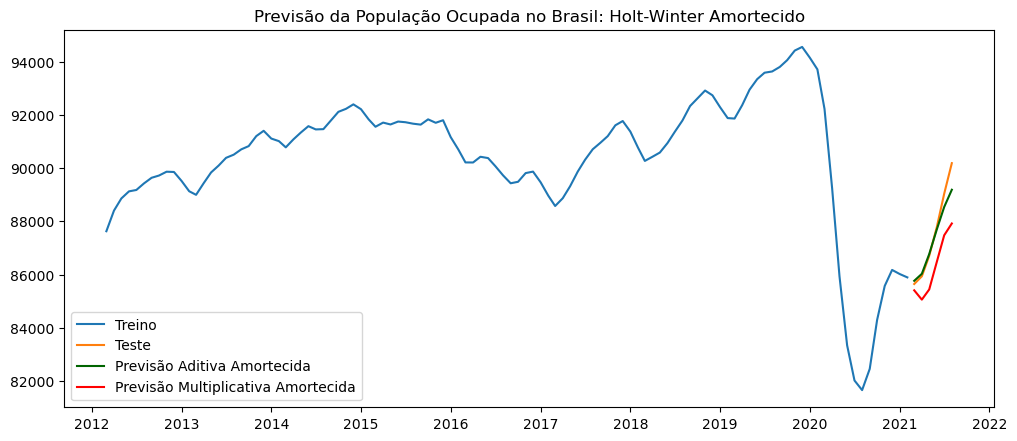

In [33]:
# Criando as séries para plottar
serie_previsao_aditivo_amort = pd.Series(previsoes_aditivo_amort, index=index_previsao)
serie_previsao_multiplicativo_amort = pd.Series(previsoes_multiplicativo_amort, index=index_previsao)

## Plottando
plt.figure(figsize=(12,5), dpi=100)
# Série de treino
plt.plot(serie_treino, label="Treino")
# Série de teste
plt.plot(serie_teste, label="Teste")

## Previsão e Valores de Confiança
plt.plot(serie_previsao_aditivo_amort, color='darkgreen', label="Previsão Aditiva Amortecida")
plt.plot(serie_previsao_multiplicativo_amort, color='red', label="Previsão Multiplicativa Amortecida")

plt.title("Previsão da População Ocupada no Brasil: Holt-Winter Amortecido")
plt.legend()
plt.show()

In [34]:
## Métricas da previsao aditiva
acuracia_previsao(previsoes_aditivo_amort, teste)

MAPE: 0.3487%
MAE: 310.7773
RMSE: 461.9416
Erro Máximo: 998.2328


In [35]:
## Métricas da previsao multiplicativa
acuracia_previsao(previsoes_multiplicativo_amort, teste)

## Dentre todas as suavizações, prefere-se a adititiva não-amortecida

MAPE: 1.4175%
MAE: 1251.3782
RMSE: 1395.9118
Erro Máximo: 2265.0563


### AR ou VAR

A equação pode ser escrita da sguinte forma:

$Y_t = A + a_1 Y_{t-1} + a_2 Y_{t-2} + ... + a_p Y_{t-p} + \epsilon_t$

Diz-se que o processo é autorregressivo de ordem $p$.

In [36]:
## Sintaxe da ordem do ARIMA: (p, d, q)
# Como no modelo AR q = 0, tem-se que
# p = 2 (vide autocorrelação parcial) e d = 0 (série já é estacionária)

## Criando o modelo
modelo_ar = ARIMA(df.ocupados.values, order=(2,0,0))
modelo_ar_fit = modelo_ar.fit()

In [37]:
## Vendo resultados
print(modelo_ar_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  114
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -830.030
Date:                Sun, 12 Dec 2021   AIC                           1668.061
Time:                        17:44:43   BIC                           1679.006
Sample:                             0   HQIC                          1672.503
                                - 114                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.027e+04    588.963    153.277      0.000    8.91e+04    9.14e+04
ar.L1          1.7943      0.038     46.678      0.000       1.719       1.870
ar.L2         -0.8606      0.034    -25.395      0.0

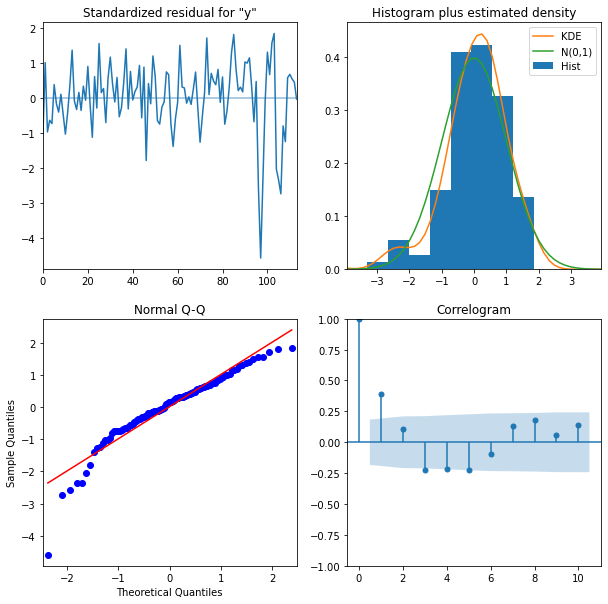

In [38]:
## Vendo diagnósticos
modelo_ar_fit.plot_diagnostics(figsize=(10, 10))
plt.show()

# De cara já vemos que o modelo não é muito bom: o erro possui autocorrelação e
# sua variância (1º plot) aumenta com o tempo

Text(0, 0.5, 'Ocupados')

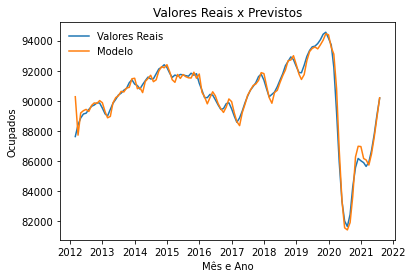

In [39]:
## Vendo como o modelo se compara com os dados
previsao_ar = modelo_ar_fit.predict()

## Adicionado previsao ao DataFrame
df['previsao_ar'] = previsao_ar

## Plottando
# Linhas e legenda
plt.plot(df.ocupados, label="Valores Reais")
plt.plot(df.previsao_ar, label="Modelo")
plt.legend(frameon=False)

# Títulos
plt.title("Valores Reais x Previstos")
plt.xlabel("Mês e Ano")
plt.ylabel("Ocupados")

### MA

A equação pode ser escrita como:

$Y_t = \mu_{Y_t} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + ... + \theta_q \epsilon_{t-q} + \epsilon_t$,

onde $\epsilon$ são ruídos brancos de distribuição normal com média 0 e $\mu_{Y_t}$ é a média da série.

Diz-se que o processo é de médias móveis de ordem $q$.

In [40]:
# Como no modelo MA p = 0, tem-se que
# d = 0 (série já é estacionária) e q = 4 (vide autocorrelação total) 

## Criando o modelo
modelo_ma = ARIMA(df.ocupados.values, order=(0, 0, 3))
modelo_ma_fit = modelo_ma.fit()

/Users/vinicius/opt/anaconda3/envs/datascience/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [41]:
## Vendo resultados
print(modelo_ma_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  114
Model:                 ARIMA(0, 0, 3)   Log Likelihood                -895.534
Date:                Sun, 12 Dec 2021   AIC                           1801.068
Time:                        17:44:44   BIC                           1814.749
Sample:                             0   HQIC                          1806.621
                                - 114                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.027e+04    329.045    274.350      0.000    8.96e+04    9.09e+04
ma.L1          1.4826      0.062     24.074      0.000       1.362       1.603
ma.L2          1.5212      0.162      9.390      0.0

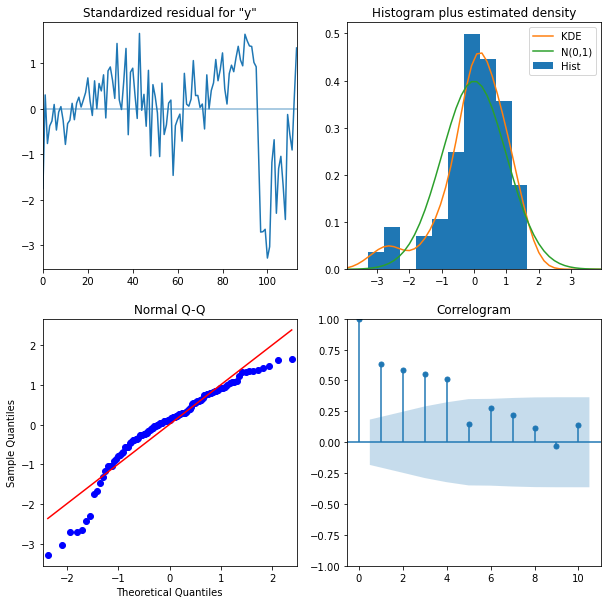

In [42]:
## Vendo diagnósticos
modelo_ma_fit.plot_diagnostics(figsize=(10, 10))
plt.show()

## De cara, já vemos que o erro possui autocorrelação e, portanto, não pode ser um ruído branco

Text(0, 0.5, 'Ocupados')

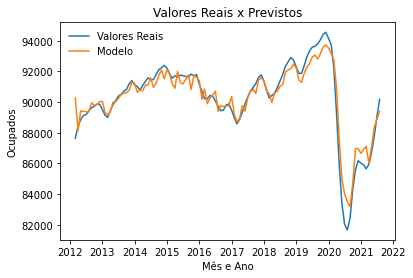

In [43]:
## Vendo como o modelo se compara com os dados
previsao_ma = modelo_ma_fit.predict()

## Adicionado previsao ao DataFrame
df['previsao_ma'] = previsao_ma

## Plottando
# Linhas e legenda
plt.plot(df.ocupados, label="Valores Reais")
plt.plot(df.previsao_ma, label="Modelo")
plt.legend(frameon=False)

# Títulos
plt.title("Valores Reais x Previstos")
plt.xlabel("Mês e Ano")
plt.ylabel("Ocupados")

### ARMA/ARIMA

ARIMA (Auto Regressive Integrated Moving Average) é uma classe de modelos que explica uma série temporal a partir de seus próprios valores anteriores.
Inicialmente, usa-se uma série **estacionária** sem sazonalidade (com sazonalidade: *SARIMA*, não contemplado aqui).

-----

A equação pode ser escrita como:

$Y_t = a_1 Y_{t-1} + a_2 Y_{t-2} + ... + a_p Y_{t-p}$ (modelo *AR*) + $\theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + ... + \theta_q \epsilon_{t-q} + \epsilon_t$ (modelo *MA*).

----

O modelo é caracterizado por três parâmetros:

- *p* é a ordem do modelo *AR* (no nosso caso, até 2);
- *q* é a ordem do modelo *MA* (no nosso caso, até 4);
- *d* é o número de diferenciações necessárias para tornar o modelo estacionário (no nosso caso, 0)

Alguns casos especiais:

- ARIMA(0, 0, 0) é um ruído branco;
- ARIMA(0, 1, 0) (ou I(1)) é um passeio aleatório
- ARIMA(1, 0, 0) NÃO é um passeio aleatório porque, provavelmente, $a_1 \neq 1$.

O primeiro passo seria diferenciar a série para torná-la estacionária.
Como nossa série já é estacionária, essa etapa pode ser pulada.

Podíamos rodar várias estimações para determinar qual é a melhor combinação de (p, q, d) que maximiza a informação do modelo.
Contudo, sabemos que, ao adicionarmos mais termos, o modelo sempre será "melhor", mas eles podem ser insignificantes e dificultar a interpretação dos demais parâmetros.

Para encontrar a melhor combinação, devemos criar um modelo que **minimize o AIC** (Critério de Informação de Akaike), que mensura a qualidade de um modelo presando também por sua simplicidade.

## Box-Jenkins: Diagnóstico (modelo ARIMA)

Como se trata de séries temporais, alguns testes de regressão podem ser diferentes.

O teste de heteroscedasticidade não é mais o de Breusch-Pagan, mas sim o de Goldfeld-Quandt, onde H0=homoscedasticidade.

No nosso exemplo, ela é rejeitada e há heteroscedasticidade (por isso usamos o cov_type='robust'), o que pode ser visto no gráfico de *standardized residuals* na figura abaixo (variância aumenta ao longo do tempo).
Apesar disso, notem que o valor da estatística *H* diminuiu bastante frente aos dois modelos anteriores.

Com isso, já sabemos que o erro não é um ruído branco puro (apesar de, como veremos mais a frente, ele possuir média 0 e 0 autocorrelação).

O teste de Jarque-Bera nos diz que, apesar de próxima, os dados não seguem uma distribuição normal, o que pode ser visto no histograma e no Normal Q-Q.

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  114
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -813.049
Date:                Sun, 12 Dec 2021   AIC                           1638.099
Time:                        17:45:08   BIC                           1654.516
Sample:                             0   HQIC                          1644.761
                                - 114                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5306.0873   2361.525      2.247      0.025     677.584    9934.591
ar.L1          1.5414      0.107     14.416      0.000       1.332       1.751
ar.L2         -0.6003      0.121     -4.963      0.0

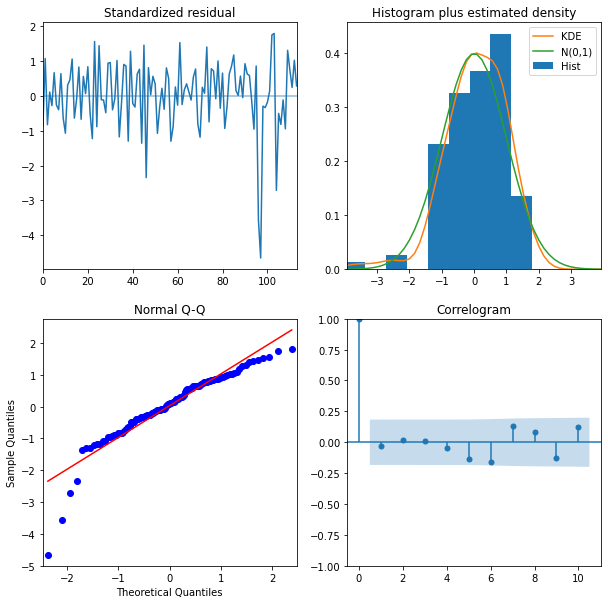

P-value for the test that residual mean is equal to 0: 0.83057.
If p < 0.05, H0 is rejected and the residual mean is different from 0 (not ideal).


In [49]:
# Rodando modelo e vendo diagnósticos
import econometric_functions as ef
modelo_arima = ef.arima_model(df.ocupados)

O último plot mostra que os resíduos não são autocorrelacionados (dentro do intervalo de significância).
Assim, os erros do modelo se devem a erros aleatórios, o que parece estar em linha com um ruído branco. Essa análise é comprovada pelo teste que a média dos resíduos não é estatisticamente diferente de 0, com um p-valor de 0,83.

### Vendo como o modelo se compara com os dados

In [50]:
## Vendo como o modelo se compara com os dados
previsao = modelo_arima.predict_in_sample((0, df['ocupados'].shape[0] - 1))

## Adicionado previsao ao DataFrame
df['previsao'] = previsao

## Erro percentual
df['erro_previsao'] = np.abs((df['ocupados'] - df['previsao']) / df['ocupados']) * 100

In [51]:
## Descrevendo erro
# maior erro: 2.85% do total
df['erro_previsao'].describe()

count    114.000000
mean       0.269583
std        0.333047
min        0.004993
25%        0.094339
50%        0.207875
75%        0.321225
max        2.849807
Name: erro_previsao, dtype: float64

In [52]:
## Vendo onde foi o maior erro: 1º més da série!
df.query('erro_previsao > 2.849')

,data,ocupados,holt_aditivo,holt_multiplicativo,previsao_ar,previsao_ma,previsao,erro_previsao
data,,,,,,,,
2012-03-01,2012-03-01,87632,88093.503251,87734.75032,90274.614053,90273.681712,90129.342624,2.849807


#### Previsão

Pseudo-R2: 0.9769.
Describing percentage errors...
count    114.000000
mean       0.269583
std        0.333047
min        0.004993
25%        0.094339
50%        0.207875
75%        0.321225
max        2.849807
Name: ErroFit, dtype: float64
Prediction values:
2021-09-01 00:00:00    91084.529287
2021-10-07 04:48:00    91609.559322
2021-11-12 09:36:00    91837.600295
2021-12-18 14:24:00    91873.928637
2022-01-23 19:12:00    91793.030013
2022-03-01 00:00:00    91646.520769
dtype: float64


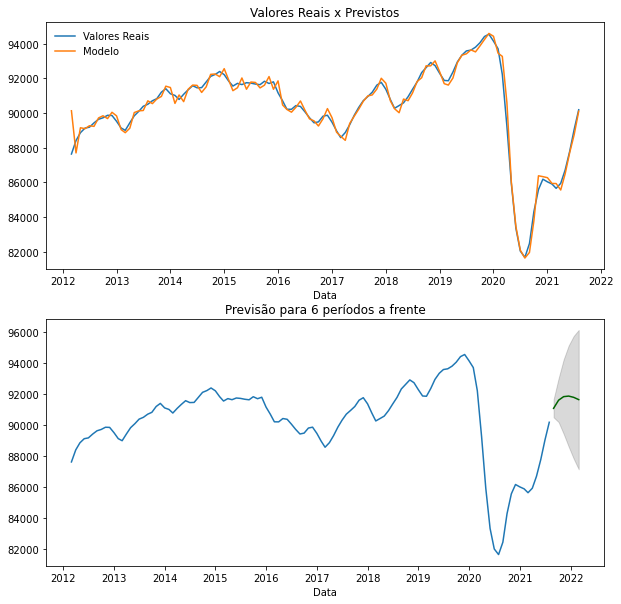

In [53]:
df, serie_previsao = ef.arima_fit_prediction(modARIMA=modelo_arima,
                                                dfData=df, sColumn="ocupados",
                                                nPeriods=6, sFreq="months")

In [54]:
## Vendo valores
# Cresce até novembro e passa a estagnar (apesar de o intervalo de confiança
# aumentar quanto mais no futuro estarmos)
# O que falta? sazonalidade!
print(serie_previsao)

2021-09-01 00:00:00    91084.529287
2021-10-07 04:48:00    91609.559322
2021-11-12 09:36:00    91837.600295
2021-12-18 14:24:00    91873.928637
2022-01-23 19:12:00    91793.030013
2022-03-01 00:00:00    91646.520769
dtype: float64


In [55]:
## Vendo últimos valores
print(df['ocupados'].tail(5))

data
2021-04-01    85940
2021-05-01    86708
2021-06-01    87791
2021-07-01    89042
2021-08-01    90188
Freq: MS, Name: ocupados, dtype: int64


## Box-Jenkins: Previsão (modelo ARIMA)

Vamos ver como o modelo se compara aos valores reais dos últimos seis meses disponíveis na série. 



In [56]:
## Fittando o modelo
modelo_arima_teste = auto_arima(treino, trace=False)
modelo_arima_teste.fit(y=treino, cov_type='robust')

ARIMA(order=(2, 0, 2), scoring_args={}, suppress_warnings=True)

In [57]:
## Sumário
print(modelo_arima_teste.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  108
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -771.239
Date:                Sun, 12 Dec 2021   AIC                           1554.479
Time:                        17:45:16   BIC                           1570.571
Sample:                             0   HQIC                          1561.004
                                - 108                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5667.1860   2638.574      2.148      0.032     495.676    1.08e+04
ar.L1          1.5091      0.119     12.683      0.000       1.276       1.742
ar.L2         -0.5722      0.136     -4.211      0.0

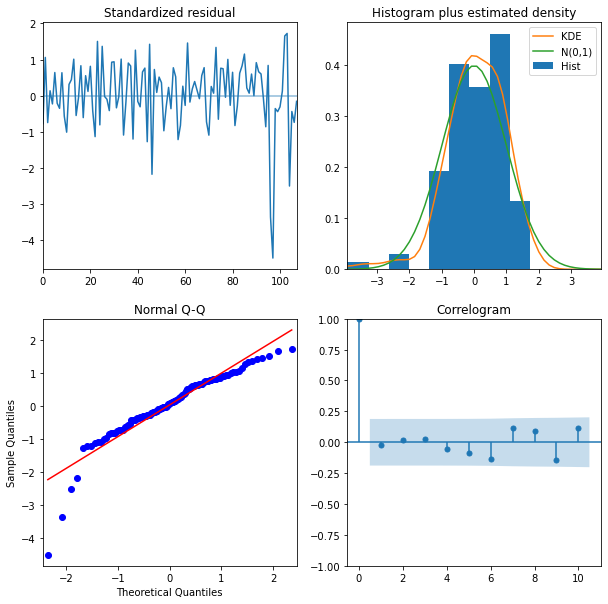

In [58]:
## Vendo diagnósticos
modelo_arima_teste.plot_diagnostics(figsize=(10, 10))
plt.show()

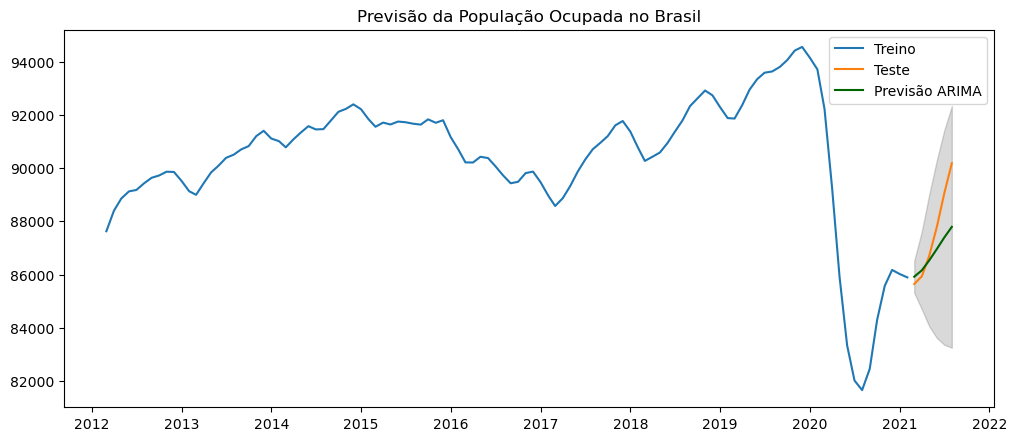

In [59]:
## Prevendo os últimos 6 meses
previsao, confint = modelo_arima_teste.predict(n_periods=nMeses, return_conf_int=True)
## Criando indexes para os dados da previsão
index_previsao = pd.date_range(start=f'{9 - nMeses}/1/2021', periods=nMeses, freq="MS")

# Criando a Série para plottar
serie_previsao = pd.Series(previsao, index=index_previsao)
lower_series = pd.Series(confint[:, 0], index=index_previsao)
upper_series = pd.Series(confint[:, 1], index=index_previsao)

## Plottando
plt.figure(figsize=(12,5), dpi=100)
# Série de treino
plt.plot(serie_treino, label="Treino")
# Série de teste
plt.plot(serie_teste, label="Teste")

## Previsão e Valores de Confiança
plt.plot(serie_previsao, color='darkgreen', label="Previsão ARIMA")
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

plt.title("Previsão da População Ocupada no Brasil")
plt.legend()
plt.show()

In [60]:
## Vendo valores
pd.DataFrame([serie_previsao, serie_teste], index=["Previsão", "Real"])

,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01
Previsão,85924.17501,86163.87259,86536.989068,86962.926663,87392.239205,87796.421713
Real,85650.00000,85940.00000,86708.000000,87791.000000,89042.000000,90188.000000


In [61]:
## Vendo métricas
# Mape de 1,03% indica que o modelo é, em média 98,97% acurado na previsão dos valores dos próximos 6 meses
acuracia_previsao(previsao, teste)

MAPE: 1.0376%
MAE: 923.0785
RMSE: 1243.7576
Erro Máximo: 2391.5783


In [62]:
## Vendo métrica do melhor modelo de suavização
acuracia_previsao(previsoes_aditivo, teste)

# Melhor modelo: ARIMA (por pouco)

MAPE: 0.3128%
MAE: 278.1994
RMSE: 403.8644
Erro Máximo: 876.9944


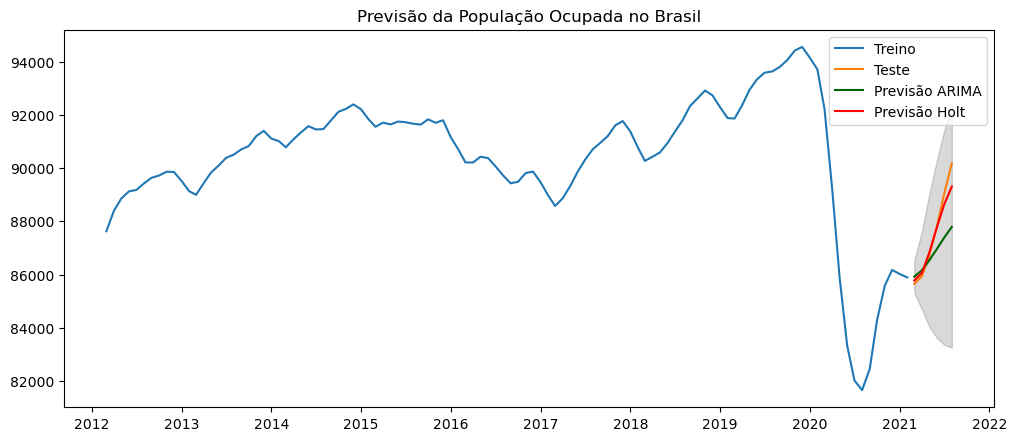

In [63]:
## Plottando as previsões juntas
plt.figure(figsize=(12,5), dpi=100)
# Série de teste
plt.plot(serie_treino, label="Treino")
plt.plot(serie_teste, label="Teste")

## Previsão e Valores de Confiança
plt.plot(serie_previsao, color='darkgreen', label="Previsão ARIMA")
plt.plot(serie_previsao_aditivo, color='red', label="Previsão Holt")
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

plt.title("Previsão da População Ocupada no Brasil")
plt.legend()
plt.show()

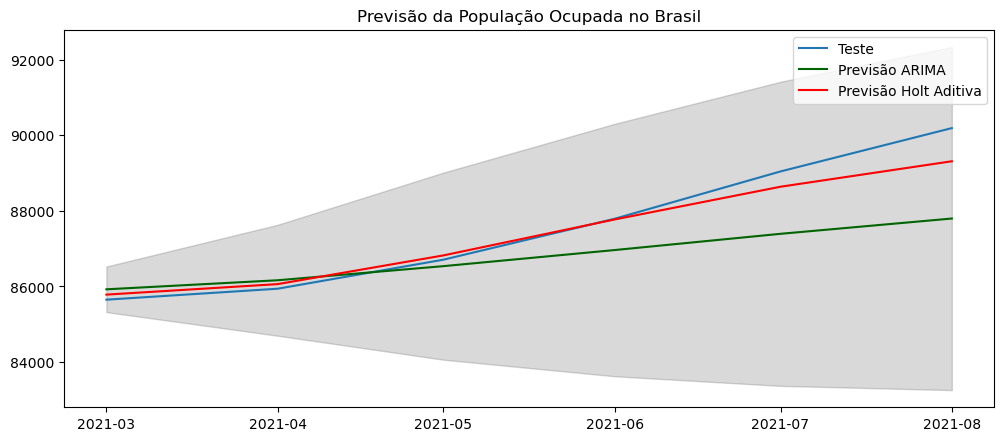

In [64]:
## Plottando (com zoom) as previsões juntas
plt.figure(figsize=(12,5), dpi=100)
# Série de teste
plt.plot(serie_teste, label="Teste")

## Previsão e Valores de Confiança
plt.plot(serie_previsao, color='darkgreen', label="Previsão ARIMA")
plt.plot(serie_previsao_aditivo, color='red', label="Previsão Holt Aditiva")
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

plt.title("Previsão da População Ocupada no Brasil")
plt.legend()
plt.show()

Accuracy Metrics:
MAPE: 0.6419%
MAE: 575.9274
RMSE: 716.1535
Erro Máximo: 1122.8001

Test x Prediction:
                Previsão     Real
2021-06-01  87706.392118  87791.0
2021-07-01  88521.625881  89042.0
2021-08-01  89065.199928  90188.0


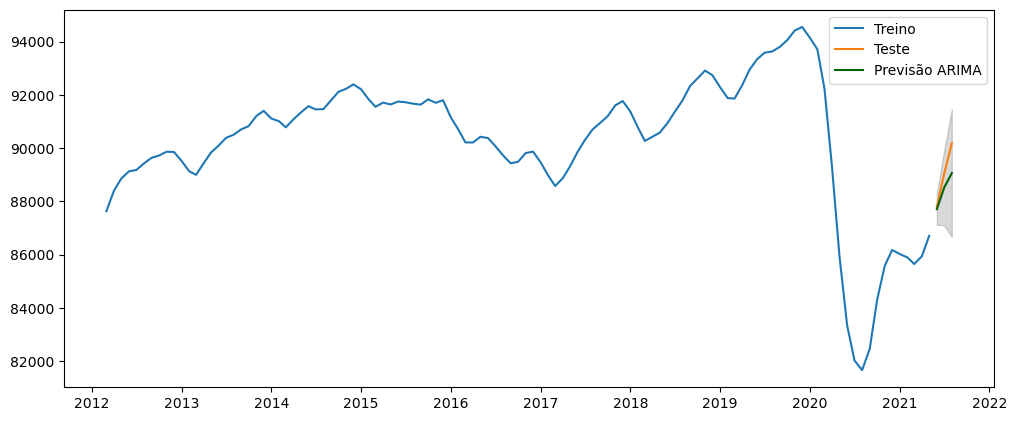

In [65]:
# 3 meses a frente
dfPrevisaoTeste = ef.arima_train_test_prediction(df, "ocupados", 3, "months")

# Obrigado!